# 0.0 Imports

In [23]:
!pip install xgboost==0.90

In [1]:
import math
import pickle

import pandas as pd
import numpy as np
import inflection

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy import stats as ss
#from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error #mean_absolute_percentage_error

from IPython.core.display import HTML
from IPython.display      import Image

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def ts_cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('/home/mvrcosp/repos/DSP/Rossmann/data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/home/mvrcosp/repos/DSP/Rossmann/data/raw/store.csv', low_memory=False)

In [5]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 0.3 Data Dictionary

* **Id** - an Id that represents a (Store, Date) duple within the test set

* **Store** - a unique Id for each store

* **Sales** - the turnover for any given day (this is what you are predicting)

* **Customers** - the number of customers on a given day

* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open

* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b  Easter holiday, c = Christmas, 0 = None

* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools

* **StoreType** - differentiates between 4 different store models: a, b, c, d

* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended

* **CompetitionDistance** - distance in meters to the nearest competitor store

* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

* **Promo** - indicates whether a store is running a promo on that day

* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2

* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 1.0 Data Description

## 1.1 Rename columns

In [8]:
df1 = df_raw.copy()

In [9]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [11]:
oldcols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_news = list(map(snakecase, oldcols))

df1.columns = cols_news

## 1.2 Data Exploration

In [12]:
#Data dimensions

print("number of rows: {}".format(len(df1)))
print("number of columns: {}".format(df1.shape[1]))

number of rows: 1017209
number of columns: 18


In [13]:
#Data types

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

## 1.3 Dates to datetime

In [14]:
df1['date'] = pd.to_datetime(df1['date'])

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.4 Check and fill NA

In [16]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [17]:
print(df1['competition_distance'].max())
print(df1['competition_open_since_year'].max())

75860.0
2015.0


In [18]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week         
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  

month_map = {1: 'Jan', 2: 'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [19]:
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5 Change dtypes

In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [21]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.6 Descriptive Statistics

In [23]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Numerical Attributes

In [24]:
#Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).transpose()
ct2 = pd.DataFrame(num_attributes.apply(np.median)).transpose()

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).transpose()
d2 = pd.DataFrame(num_attributes.apply(np.min)).transpose()
d3 = pd.DataFrame(num_attributes.apply(np.max)).transpose()
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).transpose()
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).transpose()
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).transpose()

#concatenate
m = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6]).transpose().reset_index()
m.columns = ['index', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']

In [25]:
m

,index,mean,median,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


/home/mvrcosp/repos/DSP/Rossmann/env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

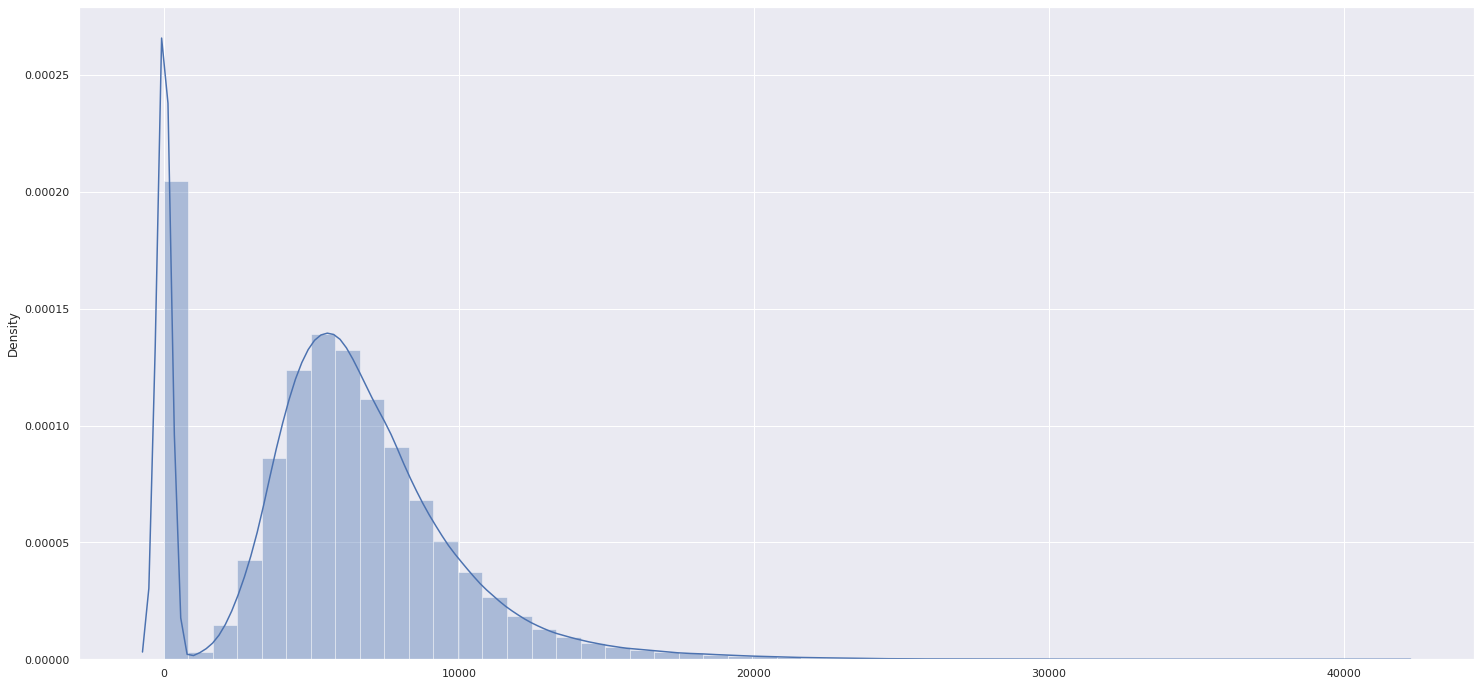

In [26]:
sns.distplot(x=df1['sales'])

### 1.6.2 Categorical attributes

In [27]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

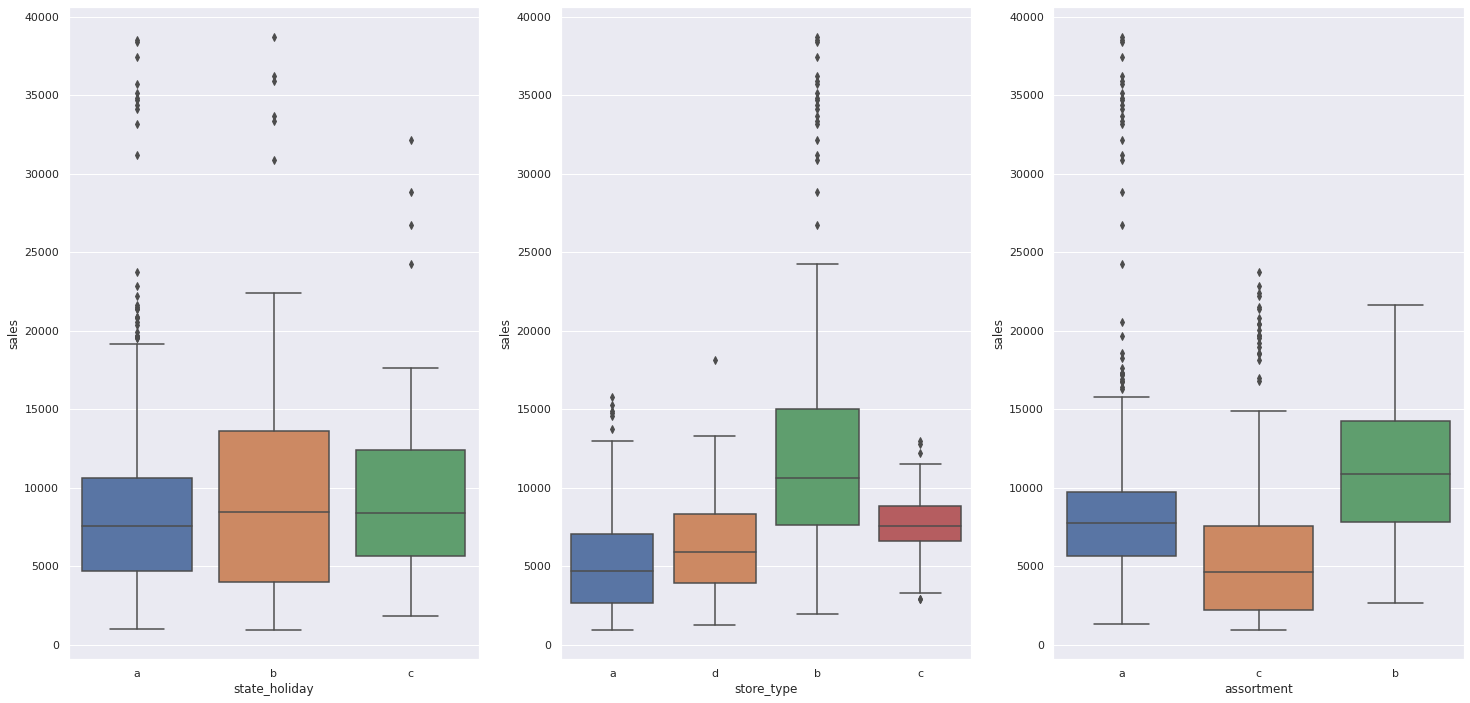

In [28]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [29]:
df2 = df1.copy()

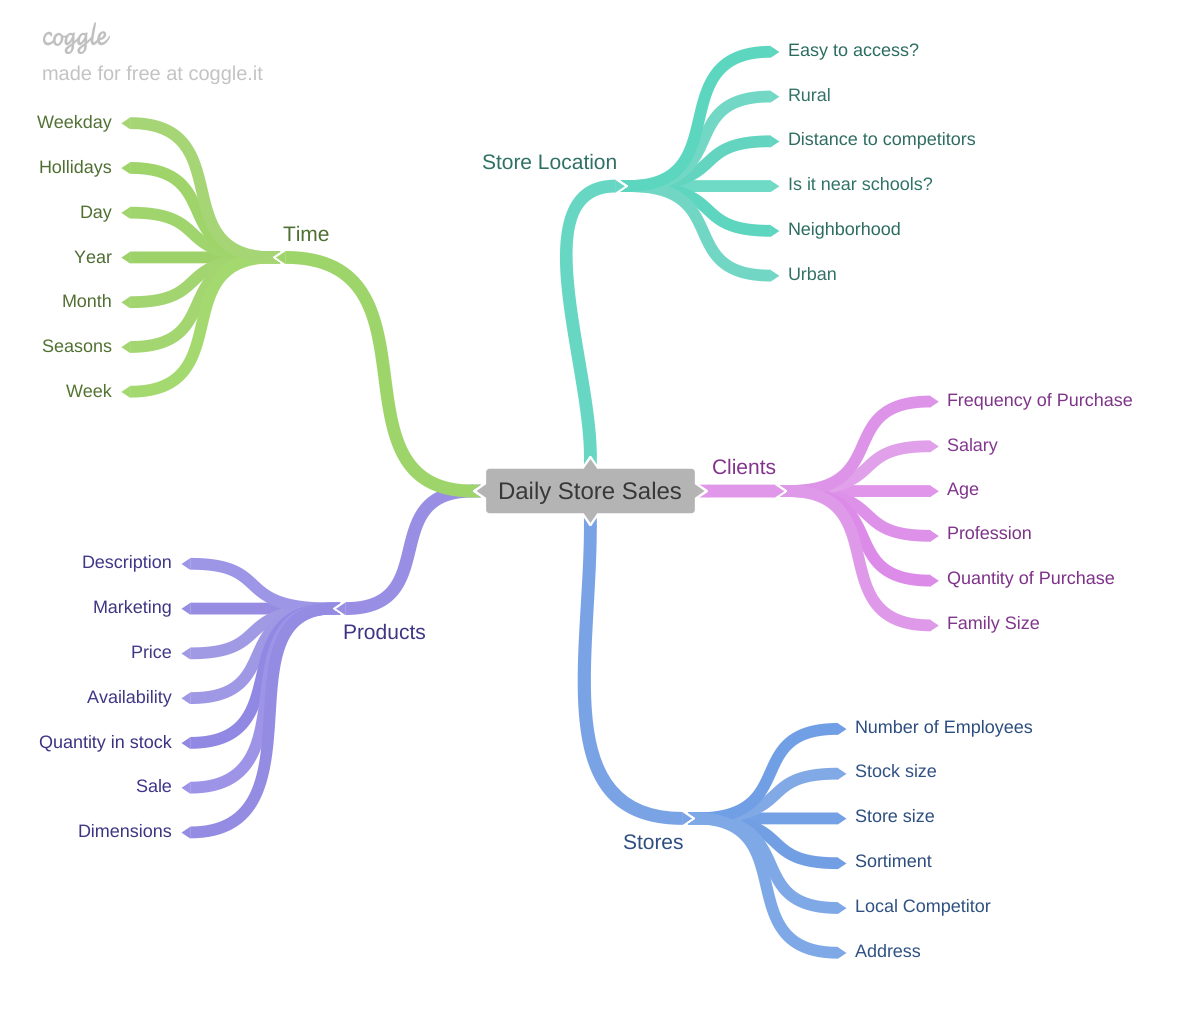

In [30]:
Image("/home/mvrcosp/repos/DSP/Rossmann/img/EngMindMapHypothesis.png")

## 2.1 Brainstorming Business Hypothesis to validate with data!

### 2.1.1 Store Hypothesis

**1.** Stores with a bigger number of employees should sell more.

**2.** Stores with a bigger stock size should sell more.

**3.** Stores with a bigger size should sell more.

**4.** Stores with local competitors should sell less.

**5.** Stores with longer-term competitors should sell more.

**6.** Stores with bigger assortment should sell more.

### 2.1.2 Product Hypothesis

**1.** Stores that invest in marketing strategies should sell more.

**2.** Stores that showcase their product better should sell more.

**3.** Stores with cheaper products should sell more.

**4.** Stores that perform more agressive promos should sell more.

**5.** Stores that keep their promos active for longer periods should sell more.

**6** Stores with consecutive promos should sell more.

### 2.1.3 Sazonality Hypothesis

**1.** Stores that open during christmas season should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more at the 2nd semester of the year.

**4.** Stores should sell more at the beginning of each month.

**5.** Stores should sell more on weekends.

**6.** Stores should sell less on school holidays.

## 2.2 Final Business Hypothesis List

**H1.** Stores with bigger assortment should sell more.

**H2.** Stores with local competitors should sell less.

**H3.** Stores with longer-term competitors should sell more.

**H4.** Stores that keep their promos active for longer periods should sell more.

**H5.** Stores with consecutive promos should sell more.

**H6.** Stores that open during christmas season should sell more.

**H7.** Stores should sell more over the years.

**H8.** Stores should sell more at the 2nd semester of the year.

**H9.** Stores should sell more at the beginning of each month.

**H10.** Stores should sell less on weekends.

**H11.** Stores should sell less on school holidays.

## 2.3 Feature Engineering

In [31]:
df2['date'] = pd.to_datetime(df2['date'])

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# Week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

/tmp/ipykernel_221956/1174253869.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 Data Filtering

In [32]:
df3 = df2.copy()

In [33]:
df3 = df3[(df3["open"] != 0) & (df3['sales'] > 0)]

In [34]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3.drop(cols_drop, inplace=True, axis=1)

In [35]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [36]:
df3.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

# 4.0 Exploratory Data Analysis

In [37]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.1.1 Target Variable

In [ ]:
sns.distplot(df4['sales'], kde=False)

### 4.1.2 Numerical Variables

In [ ]:
num_attributes.hist(bins=25)
plt.show()

### 4.1.3 Categorical Variables

In [ ]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x = 'state_holiday', data = a )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot(x = 'store_type', data = df4)

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x = 'assortment', data = df4)

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

plt.show()

## 4.2 Bivariate Analysis - Validating Business Hypothesis

### 4.2.1 - H1 - Stores with bigger assortment should sell more.

**False:** Stores with extended assortment do sell more than stores with basic assortment, but, stores that sell the most are the ones with only "extra" assortment (mot extended).

In [ ]:
aux421_1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x = 'assortment', y ='sales', data = aux421_1)

In [ ]:
aux421_2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux421_2.pivot(index='year_week', columns='assortment', values='sales').plot()

In [ ]:
aux421_2[aux421_2['assortment'] =='extra'].plot()

### 4.2.2 - H2 - Stores with local competitors should sell less.
**False:** Stores with competitors close by, in reality, sell more.

In [ ]:
aux422_1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux422_1)


plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux422_1['competition_distance_binned'] = pd.cut(aux422_1['competition_distance'], bins = bins)
aux422_2 = aux422_1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux422_2)
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
heat = sns.heatmap(aux422_1.corr(method='pearson'), annot=True)

plt.show()

### 4.2.3 - H3 - Stores with longer-term competitors should sell more.
**False:** In reality, stores with longer-term competitiors sell less.

In [ ]:
aux423_1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux423_2 = aux423_1[( aux423_1['competition_time_month'] < 120 ) & ( aux423_1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux423_2 );
plt.xticks( rotation=90 );

In [ ]:
plt.subplot( 1, 2, 1 )
sns.scatterplot( x='competition_time_month', y='sales', data=aux423_2 );

plt.subplot( 1, 2, 2 )
x = sns.heatmap( aux423_1.corr( method='pearson'), annot=True );

### 4.2.4 - H4 - Stores that keep their promos active for longer periods should sell more.

**False:** Actually sales start to drop after a few weeks in promotion.

In [ ]:
aux424_1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux424_2 = aux424_1[aux424_1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux424_2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux424_2 );

plt.subplot( grid[1,0] )
aux424_3 = aux424_1[aux424_1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux424_3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux424_3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux424_1.corr( method='pearson' ), annot=True );

### 4.2.5 - H5 - Stores with consecutive promos should sell more.

**False:** Stores with consecutive promos actually sell less than stores with only promo 1.

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().sort_values(by='sales').reset_index()

In [ ]:
 aux425_1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux425_1.plot()

aux425_2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux425_2.plot( ax=ax )

ax.legend( labels=['Promo 1 & Promo 2', 'Promo 1']);

### 4.2.6 - H6 - Stores that open during christmas season should sell more.

**False:** Public holidays sell better than christmas. Sorry santa :(

In [ ]:
aux426_1 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux426_2 = aux426_1[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux426_2 );

plt.subplot( 1, 2, 2 )
aux426_3 = aux426_1[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux426_3 ); 

### 4.2.7 - H7 - Stores should sell more over the years.

**False:** Stores are selling less over the years.

In [ ]:
 aux427_1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux427_1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux427_1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux427_1.corr( method='pearson' ), annot=True );

### 4.2.8 - H8 - Stores should sell more at the 2nd semester of the year.

**False:** Stores sell more at first semester of the year.

In [ ]:
aux428_1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux428_1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux428_1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux428_1.corr( method='pearson' ), annot=True );

### 4.2.9 - H9 - Stores should sell more at the beginning of each month.

**True:** Stores do sell a little bit more at the beginning of the month.

In [ ]:
plt.subplot(1, 2, 1)
aux429_1 = df4[['year', 'month', 'day', 'sales']].groupby(['year', 'month', 'day']).sum().reset_index()
sns.barplot(x='day', y='sales', data=aux429_1)

plt.subplot(1, 2, 2)
bins = list(np.arange(0, 40, 10))
aux429_1['days_binned'] = pd.cut(aux429_1['day'], bins = bins)
sns.barplot(x='days_binned', y='sales', data=aux429_1)

### 4.2.10 - H10 - Stores should sell less on weekends.

**True:** Stores DO sell less on weekends compared to weekdays.

In [ ]:
aux4210_1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux4210_1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux4210_1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux4210_1.corr( method='pearson' ), annot=True );

### 4.2.11 - H11 - Stores should sell less on school holidays.

**True:** Stores do sell less on school holidays. August is the only month where school holidays actually sell more.

In [ ]:
aux4211_1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux4211_1 );

aux4211_2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux4211_2 );

### 4.2.12 - Final Hypothesis table

In [ ]:
from tabulate import tabulate

In [ ]:
tab =[['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Low'],  
      ['H2', 'False', 'Medium'],  
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'Low'],
      ['H5', 'False', 'Low'],
      ['H6', 'False', 'Medium'],
      ['H7', 'False', 'High'],
      ['H8', 'True', 'High'],
      ['H9', 'True', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'Low']]  

print(tabulate(tab, headers='firstrow'))

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorial Attributes

In [ ]:
b = df4.select_dtypes('object')
b.drop('year_week', axis=1, inplace=True)

In [ ]:
#Calculte Cramer V

b1 = cramer_v( b['state_holiday'], b['state_holiday'] )
b2 = cramer_v( b['state_holiday'], b['store_type'] )
b3 = cramer_v( b['state_holiday'], b['assortment'] )

b4 = cramer_v( b['store_type'], b['state_holiday'] )
b5 = cramer_v( b['store_type'], b['store_type'] )
b6 = cramer_v( b['store_type'], b['assortment'] )

b7 = cramer_v( b['assortment'], b['state_holiday'] )
b8 = cramer_v( b['assortment'], b['store_type'] )
b9 = cramer_v( b['assortment'], b['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [b1, b2, b3], 
               'store_type': [b4, b5, b6],
               'assortment': [b7, b8, b9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0 Data Preparation

In [38]:
df5 = df4.copy()

## 5.1 Rescaling (Numerical Attributes)

In [39]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [40]:
 rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
#pickle.dump( rs, open( '/home/mvrcosp/repos/DSP/Rossmann/Pickles/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
#pickle.dump( rs, open( '/home/mvrcosp/repos/DSP/Rossmann/Pickles/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
#pickle.dump( rs, open( '/home/mvrcosp/repos/DSP/Rossmann/Pickles/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
#pickle.dump( mms, open( '/home/mvrcosp/repos/DSP/Rossmann/Pickles/year_scaler.pkl', 'wb') )

## 5.2 Encoding (Categorical Attributes)

In [41]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [42]:
 # state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
#pickle.dump( le, open( '/home/mvrcosp/repos/DSP/Rossmann/Pickles/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

## 5.3 Target Variable Transformation (Logarithm Transformation)

In [43]:
df5['sales'] = np.log1p( df5['sales'] )

/home/mvrcosp/repos/DSP/Rossmann/env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

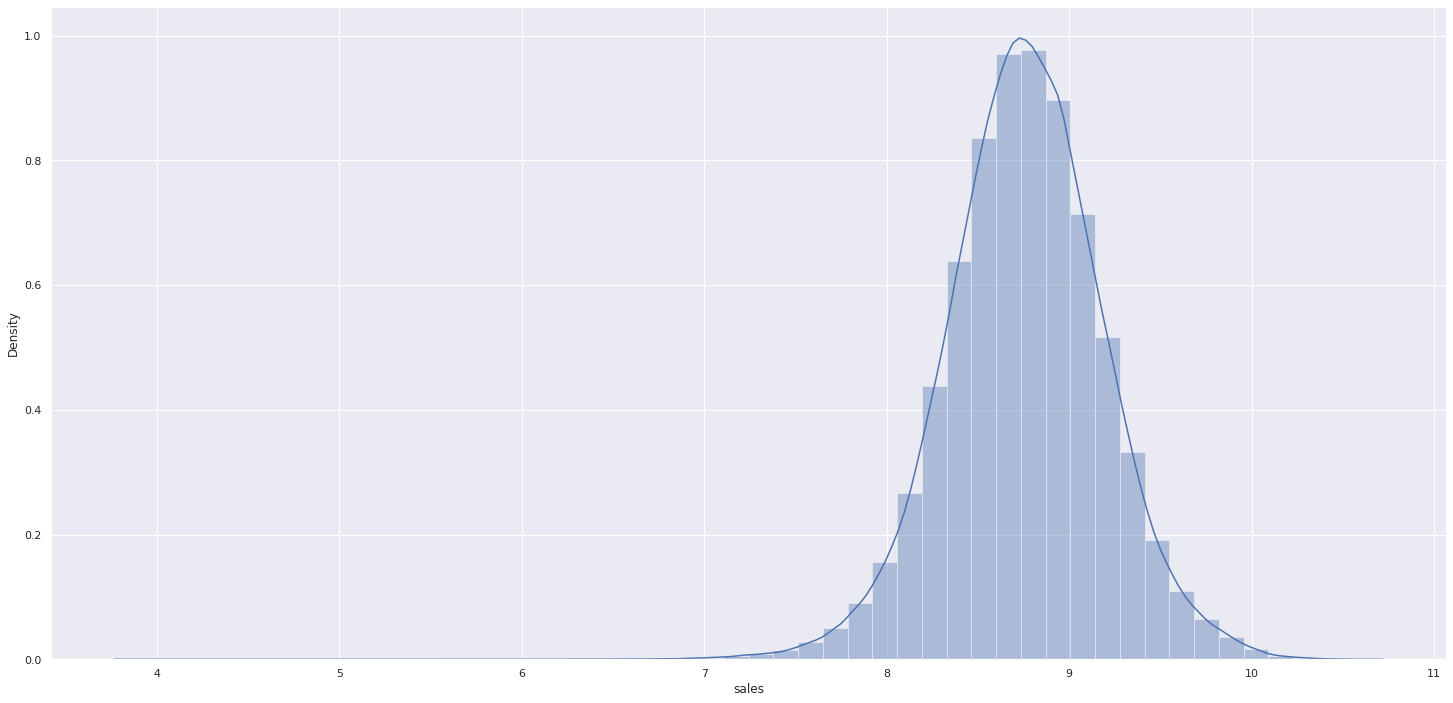

In [49]:
sns.distplot(df5.sales)

## 5.4 Dealing With the Cyclic Nature of Time

In [44]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 Feature Selection

In [45]:
df6 = df5.copy()

## 6.1 Split DataFrame into Traning and Test Dataset

In [46]:
cols_to_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6.drop(cols_to_drop, axis=1, inplace=True)

In [47]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [48]:
#y_train.to_pickle(open("/home/mvrcosp/repos/DSP/Rossmann/data/processed/y_train.pkl", "wb"))
#y_test.to_pickle(open("/home/mvrcosp/repos/DSP/Rossmann/data/processed/y_test.pkl", "wb"))
#X_test.to_pickle(open("/home/mvrcosp/repos/DSP/Rossmann/data/processed/X_test.pkl", "wb"))
#X_train.to_pickle(open("/home/mvrcosp/repos/DSP/Rossmann/data/processed/X_train.pkl", "wb"))

## 6.2 Boruta Algorithm to Select Features

In [49]:
# training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1 Best Features from Boruta

In [50]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3 Manual Feature Selection

In [51]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [52]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Model Data

In [53]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation to cross validation
x_training = X_train[cols_selected_boruta_full]

In [65]:
#x_train.to_pickle(open("/home/mvrcosp/repos/DSP/Rossmann/data/processed/x_train.pkl", "wb"))
#x_test.to_pickle(open("/home/mvrcosp/repos/DSP/Rossmann/data/processed/x_test.pkl", "wb"))
#x_training.to_pickle(open("/home/mvrcosp/repos/DSP/Rossmann/data/processed/x_training.pkl", "wb"))

## 7.1 Average Model - Baseline

In [77]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ))
baseline_result

## 7.2 Linear Regression Model

In [78]:
 # model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ))
lr_result

### 7.2.1 Linear Regression Model - Cross Validation

In [79]:
lr_result_cv = ts_cross_validation (x_training, 5, "Linear Regression", lr, verbose= False)
lr_result_cv

## 7.3 Linear Regression Regularized Model - Lasso

In [80]:
 # model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

### 7.3.1 Lasso - Cross Validation

In [81]:
lrr_result_cv = ts_cross_validation(x_training, 5, "Lasso", lrr, verbose=False)
lrr_result_cv

## 7.4  Random Forest Regressor

In [82]:
 # model
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit( x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [83]:
rf_result_cv = ts_cross_validation(x_training, 5, "Random Forest Regressor", rf, verbose=True)
rf_result_cv

## 7.5  XGBoost Regressor

In [84]:
 # model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb ))
xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [85]:
xgb_result_cv = ts_cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

## 7.6 Comparing Models Performance

### 7.6.1 Single Performance

In [86]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

### 7.6.2 Real Performance - Cross Validation

In [87]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

In [94]:
with open("model_result_cv.pkl", "wb") as f:
    pickle.dump(modelling_result_cv, f)

# 8.0 Hyperparameter fine tuning

## 8.1 Random Search

In [ ]:
# Random Search
# Grid Search

param = {'n_estimators': [int(x) for x in np.linspace(start = 1500, stop = 3500, num = 5)],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],,
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytee': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15],
        }

MAX_EVAL = 5

In [ ]:
#final result
final_result = pd.DataFrame()

for i in range ( MAX_EVAL ):
    hp = {k: random.sample (v, 1)[0] for k, v in param.items()}
    print(hp)
    
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators = hp['n_estimators'],
                                 eta = hp['eta'], 
                                 max_depth = hp['max_depth'],
                                 subsample = hp['subsample'],
                                 colsample_bytee = hp['colsample_bytee'],
                                 min_child_weight = hp['min_child_weight'])
    
    #performance
    
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

In [ ]:
final_result

# 8.2 Final Model

In [103]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytee': 0.7,
    'min_child_weight': 3
}

In [105]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators = param_tuned['n_estimators'],
                                 eta = param_tuned['eta'], 
                                 max_depth = param_tuned['max_depth'],
                                 subsample = param_tuned['subsample'],
                                 colsample_bytee = param_tuned['colsample_bytee'],
                                 min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned


with open("model_rossmann.pkl", "wb") as f:
    pickle.dump(model_xgb_tuned, f)

In [106]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

# 9.0  Interpreting Results

In [55]:
pred = pickle.load(open("/home/mvrcosp/repos/DSP/Rossmann/model/yhat_xgb_tuned.pkl", "rb"))

In [57]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9["sales"] = np.expm1(df9["sales"])
df9["predictions"] = np.expm1(pred)

/tmp/ipykernel_221956/3780370736.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9["sales"] = np.expm1(df9["sales"])
/tmp/ipykernel_221956/3780370736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9["predictions"] = np.expm1(pred)


In [58]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,5263.0,5488.889648
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,6064.0,5185.131836
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,8314.0,9592.420898
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,13995.0,11972.115234
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,4822.0,6405.284180


## 9.1 Business Performance

In [59]:
# sum of predictions
df91 = df9[["store", "predictions"]].groupby("store").sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [60]:
df92.sort_values("MAPE", ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.085938,100714.981535,107351.190340,3318.104402,0.565828
908,909,238233.875000,230573.337254,245894.412746,7660.537746,0.520433
875,876,203030.156250,199110.952414,206949.360086,3919.203836,0.305099
721,722,353005.781250,351013.625119,354997.937381,1992.156131,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


<AxesSubplot:xlabel='store', ylabel='MAPE'>

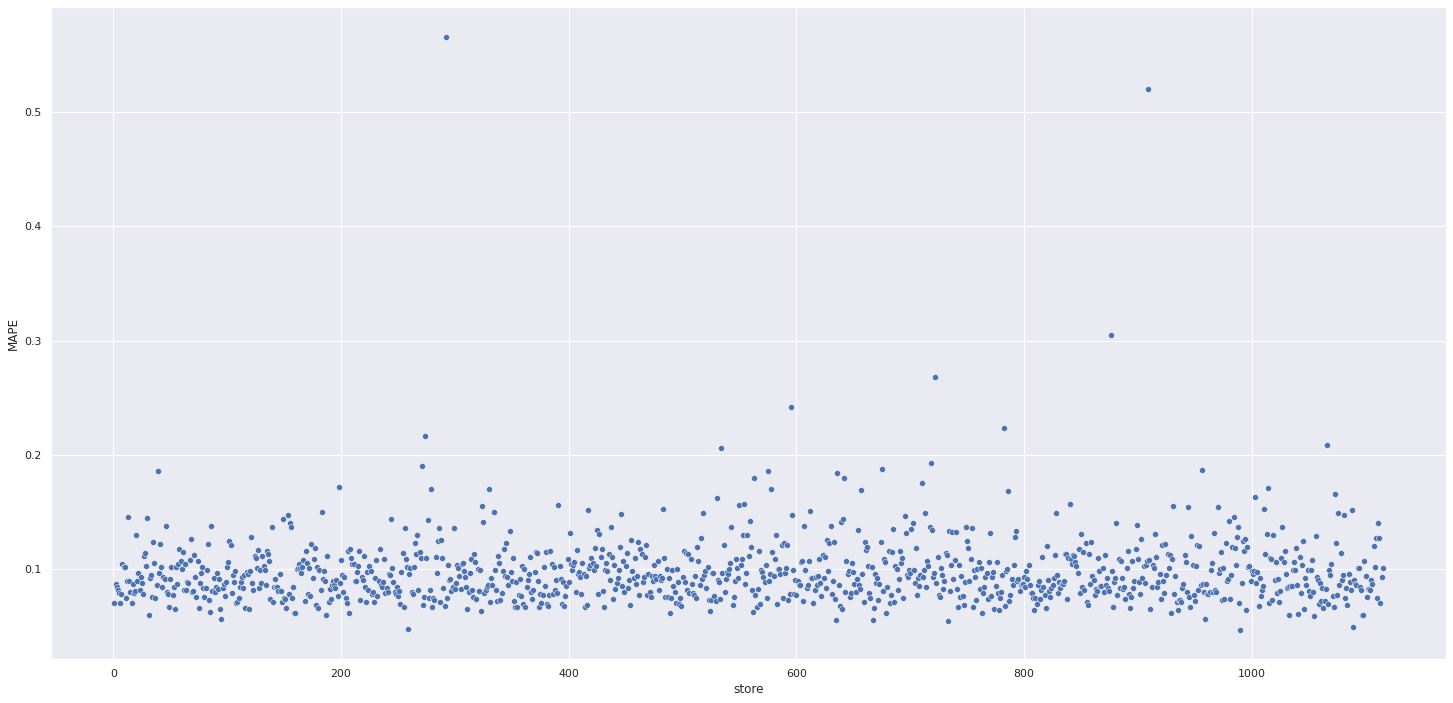

In [61]:
sns.scatterplot(x = "store", y = "MAPE", data = df92)

## 9.2 Total Performance

In [62]:
df93 = df92[["predictions", "worst_scenario", "best_scenario"]].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {"index" : "Scenario", 0: "Values"})
df93["Values"] = df93["Values"].map("R${:,.2f}".format)
df93

,Scenario,Values
0,predictions,"R$285,860,480.00"
1,worst_scenario,"R$285,115,015.78"
2,best_scenario,"R$286,605,979.91"


## 9.3 Machine Learning Performance

In [63]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipykernel_221956/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/tmp/ipykernel_221956/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/home/mvrcosp/repos/DSP/Rossmann/env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mvrcosp/repos/DSP/Rossmann/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

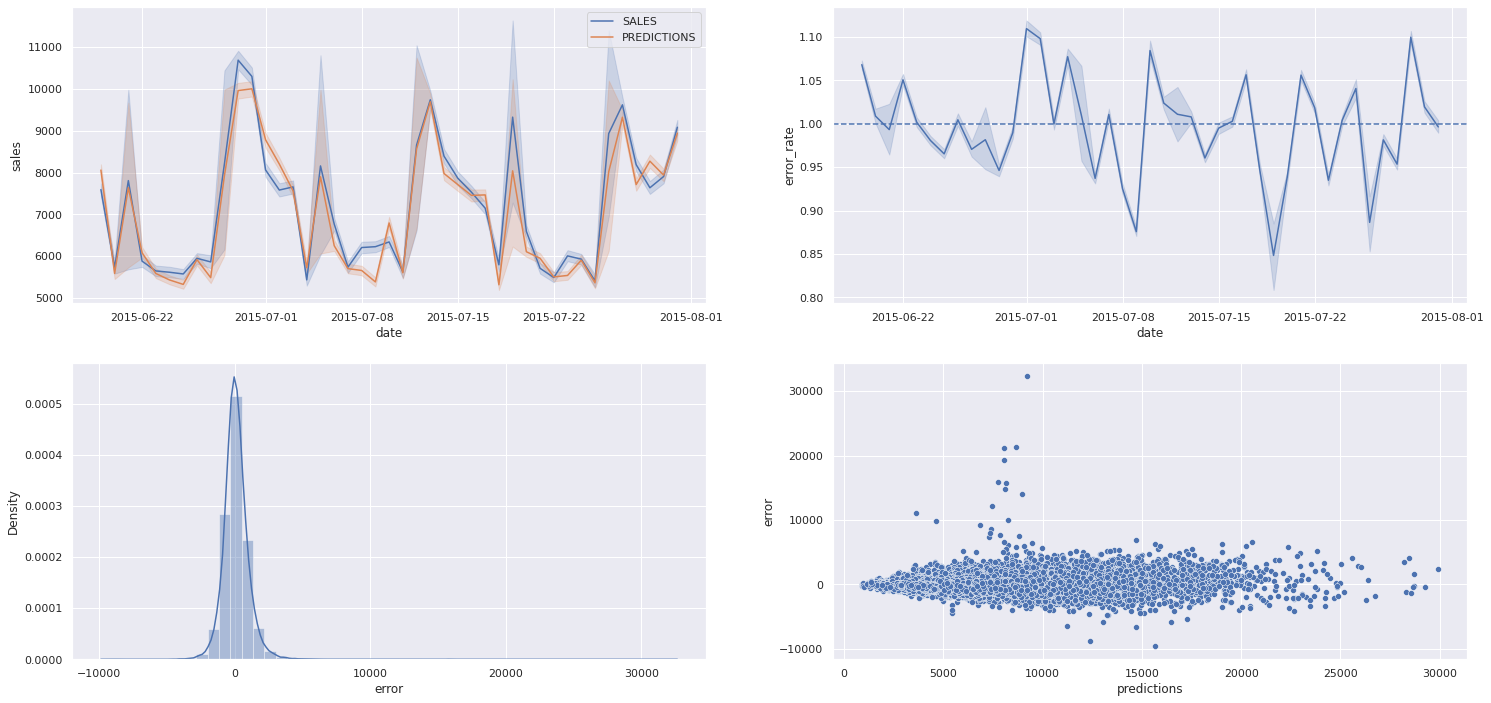

In [64]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )